## Install modules


In [ ]:
%pip install --upgrade pip
# %pip install fasttext
# %pip install imblearn
%pip install kaggle
# %pip install matplotlib
# %pip install numpy
# %pip install pandas
# %pip install scikit-learn
# %pip install seaborn
%pip install "tensorflow[and-cuda]==2.15.*"
%pip install --upgrade keras-nlp
%pip install "keras==2.15.*"

## Set up kaggle and download dataset


In [ ]:
# Upload kaggle.json
from google.colab import files

files.upload()

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d rajgupta2019/druggie
!unzip druggie.zip
!mkdir ./data
!mv train.csv data/train.csv

## EDA and Data Cleaning


In [1]:
import pandas as pd

# Data taken from: https://www.kaggle.com/datasets/rajgupta2019/druggie
df = pd.read_csv("data/train.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32165 entries, 0 to 32164
Data columns (total 8 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   patient_id                  32165 non-null  int64  
 1   name_of_drug                32165 non-null  object 
 2   use_case_for_drug           32165 non-null  object 
 3   review_by_patient           32165 non-null  object 
 4   effectiveness_rating        32165 non-null  int64  
 5   drug_approved_by_UIC        32165 non-null  object 
 6   number_of_times_prescribed  32165 non-null  int64  
 7   base_score                  32165 non-null  float64
dtypes: float64(1), int64(3), object(4)
memory usage: 2.0+ MB


In [2]:
# Check first few rows of data
df.head(10)

,patient_id,name_of_drug,use_case_for_drug,review_by_patient,effectiveness_rating,drug_approved_by_UIC,number_of_times_prescribed,base_score
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27,8.022969
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192,7.858458
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17,6.341969
3,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37,6.590176
4,155963,Cialis,Benign Prostatic Hyperplasia,"""2nd day on 5mg started to work with rock hard...",2,28-Nov-15,43,6.144782
5,48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1,5.691792
6,75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10,9-Mar-17,54,8.563274
7,219869,Amitriptyline,ibromyalgia,"""I&#039;ve been taking amitriptyline since Jan...",9,15-Mar-17,39,7.301039
8,212077,Lamotrigine,Bipolar Disorde,"""I&#039;ve been on every medicine under the su...",10,9-Nov-14,18,6.633970
9,12372,Atripla,HIV Infection,"""Spring of 2008 I was hospitalized with pnuemo...",8,9-Jul-10,11,6.562116


In [3]:
# Check for missing values
df.isna().sum()

patient_id                    0
name_of_drug                  0
use_case_for_drug             0
review_by_patient             0
effectiveness_rating          0
drug_approved_by_UIC          0
number_of_times_prescribed    0
base_score                    0
dtype: int64

In [4]:
# Create text column
df["text"] = (
    "Drug was used for " + df["use_case_for_drug"] + ". " + df["review_by_patient"]
)
# Bin effectiveness rating (1 for positive, 0 for negative)
df["label"] = df["effectiveness_rating"].apply(lambda x: 1 if x > 6 else 0)

df = df[["text", "label"]]

In [5]:
import re

# Remove numbers, special characters, and text in parentheses
df["text"] = df["text"].map(lambda s: re.sub(r"\([^\(\)]*\)|[^\w ]|\w*\d+\w*", " ", s))
# Remove extra spaces
df["text"] = df["text"].map(lambda s: re.sub(r" +", " ", s))
# Convert to lower case
df["text"] = df["text"].map(lambda s: s.strip().lower())

In [6]:
# Drop duplicates
df = df.drop_duplicates(subset=["text"])

In [7]:
# Data is imbalanced, oversampling will be done later when the text is vectorised
df["label"].value_counts()

1    20012
0    10150
Name: label, dtype: int64

In [8]:
# Show cleaned data
print(f"No. of rows: {df.shape[0]}")
df.head(10)

No. of rows: 30162


,text,label
0,drug was used for left ventricular dysfunction...,1
1,drug was used for adhd my son is halfway throu...,1
2,drug was used for birth control i used to take...,0
3,drug was used for opiate dependence suboxone h...,1
4,drug was used for benign prostatic hyperplasia...,0
5,drug was used for birth control i had been on ...,1
6,drug was used for depression i have taken anti...,1
7,drug was used for ibromyalgia i ve been taking...,1
8,drug was used for bipolar disorde i ve been on...,1
9,drug was used for hiv infection spring of i wa...,1


In [9]:
# Save cleaned data
df.to_csv("data/clean.csv", index=False)

## Models


In [10]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from seaborn import heatmap
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV

In [11]:
df = pd.read_csv("data/clean.csv")
X_train, X_val, y_train, y_val = train_test_split(
    df["text"], df["label"], test_size=0.2
)


def show_eval(model, X_train, X_val, y_train, y_val):
    print(f"Train accuracy: {model.score(X_train, y_train) * 100:.3f}%")
    print(f"Test accuracy: {model.score(X_val, y_val) * 100:.3f}%")

    y_pred = model.predict(X_val)
    print(classification_report(y_val, y_pred))
    heatmap(confusion_matrix(y_val, y_pred), annot=True, fmt="d")
    plt.show()


def transform_oversample(encoder, X_train, X_val, y_train, y_val):
    X_train = encoder.fit_transform(X_train)
    X_val = encoder.transform(X_val)

    smote = SMOTE()
    X_train, y_train = smote.fit_resample(X_train, y_train)

    return X_train, X_val, y_train, y_val.copy()

### Logistic Regression


In [12]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

# Bag of words
cv = CountVectorizer(strip_accents="unicode", stop_words="english")
X_train_lr, X_val_lr, y_train_lr, y_val_lr = transform_oversample(
    cv, X_train, X_val, y_train, y_val
)

Train accuracy: 91.834%
Test accuracy: 76.264%
              precision    recall  f1-score   support

           0       0.63      0.71      0.67      2014
           1       0.84      0.79      0.82      4019

    accuracy                           0.76      6033
   macro avg       0.74      0.75      0.74      6033
weighted avg       0.77      0.76      0.77      6033



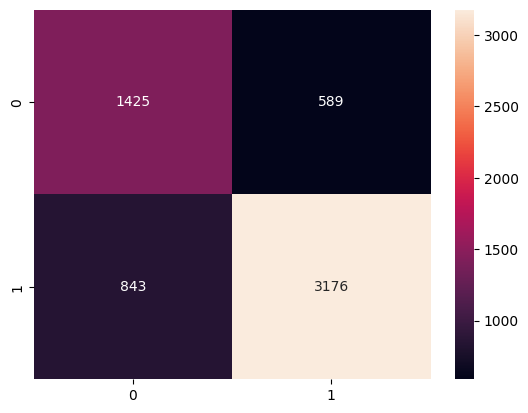

In [13]:
# Logistic regression model
lr = GridSearchCV(
    LogisticRegression(max_iter=1000),
    param_grid={
        "C": np.logspace(-3, 3, 7),
        "solver": ["newton-cg", "lbfgs", "saga"],
    },
    n_jobs=4,
    cv=3,
)
lr.fit(X_train_lr, y_train_lr)

show_eval(lr, X_train_lr, X_val_lr, y_train_lr, y_val_lr)

### Naive Bayes


In [14]:
from sklearn.feature_extraction.text import CountVectorizer

# Bag of n-grams
cv = CountVectorizer(
    strip_accents="unicode",
    stop_words="english",
    ngram_range=(1, 2),
    max_features=40000,
)
X_train_mnb, X_val_mnb, y_train_mnb, y_val_mnb = transform_oversample(
    cv, X_train, X_val, y_train, y_val
)

Train accuracy: 88.482%
Test accuracy: 75.651%
              precision    recall  f1-score   support

           0       0.63      0.66      0.64      2014
           1       0.83      0.80      0.81      4019

    accuracy                           0.76      6033
   macro avg       0.73      0.73      0.73      6033
weighted avg       0.76      0.76      0.76      6033



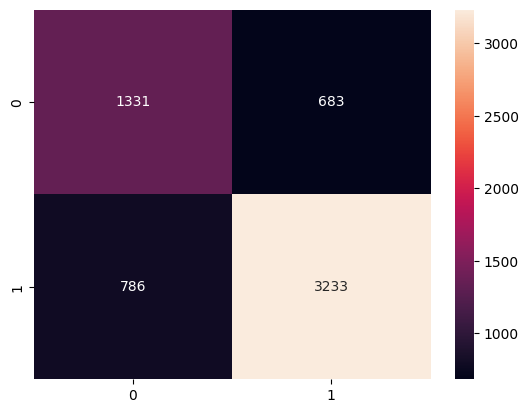

In [15]:
from sklearn.naive_bayes import MultinomialNB

# Multinomial Naive Bayes model
MNB = GridSearchCV(
    MultinomialNB(),
    param_grid={"alpha": np.linspace(0.1, 1, 10)},
    n_jobs=4,
)
MNB.fit(X_train_mnb, y_train_mnb)

show_eval(MNB, X_train_mnb, X_val_mnb, y_train_mnb, y_val_mnb)

### Support Vector Classification


In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer

# TF-IDF
tfv = TfidfVectorizer(
    strip_accents="unicode",
    stop_words="english",
    ngram_range=(1, 2),
    max_features=10000,
)
X_train_svc, X_val_svc, y_train_svc, y_val_svc = transform_oversample(
    tfv, X_train, X_val, y_train, y_val
)

Train accuracy: 93.850%
Test accuracy: 77.723%
              precision    recall  f1-score   support

           0       0.65      0.71      0.68      2014
           1       0.85      0.81      0.83      4019

    accuracy                           0.78      6033
   macro avg       0.75      0.76      0.75      6033
weighted avg       0.78      0.78      0.78      6033



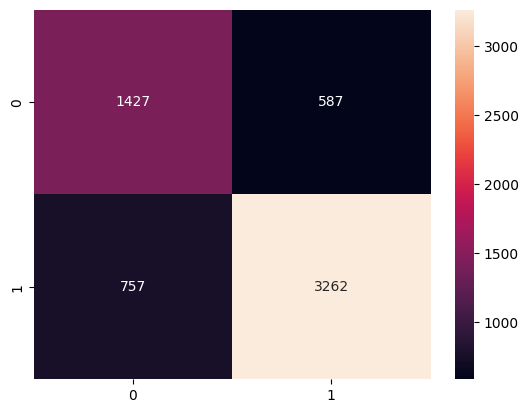

In [17]:
from sklearn.svm import LinearSVC

# Linear SVC model
linearSVC = GridSearchCV(
    LinearSVC(),
    param_grid={"loss": ["squared_hinge", "hinge"], "C": np.logspace(-3, 3, 7)},
    n_jobs=4,
    cv=3,
)
linearSVC.fit(X_train_svc, y_train_svc)

show_eval(linearSVC, X_train_svc, X_val_svc, y_train_svc, y_val_svc)

### FastText


In [18]:
# Format dataset for fasttext
train_ft = "__label__" + y_train.astype(str) + " " + X_train
train_ft.to_csv("data/fasttext.train", index=False, header=False)

Read 2M words
Number of words:  22662
Number of labels: 2
Progress: 100.0% words/sec/thread: 2648589 lr:  0.000000 avg.loss:  0.374754 ETA:   0h 0m 0s


Train accuracy: 87.961%
Test accuracy: 80.739%
              precision    recall  f1-score   support

           0       0.73      0.67      0.70      2014
           1       0.84      0.87      0.86      4019

    accuracy                           0.81      6033
   macro avg       0.79      0.77      0.78      6033
weighted avg       0.80      0.81      0.81      6033



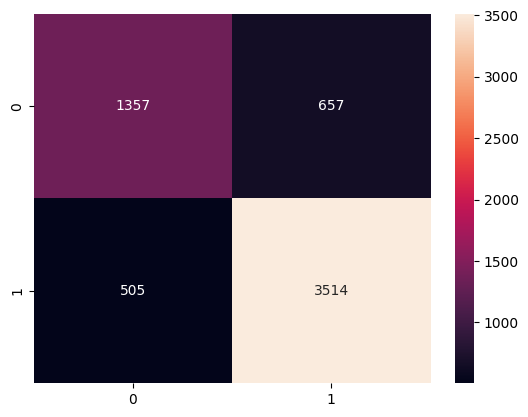

In [19]:
import fasttext

# Fasttext model
ft = fasttext.train_supervised(input="data/fasttext.train", epoch=20)

# Add methods so that show_eval can be used
ft.ft_predict = ft.predict
ft.predict = lambda X: list(
    map(lambda s: int(s[0].replace("__label__", "")), ft.ft_predict(X.to_list())[0])
)
ft.score = lambda X, y: np.mean(ft.predict(X) == y)

show_eval(ft, X_train, X_val, y_train, y_val)

### LSTM


In [20]:
import tensorflow as tf

# Create datasets
BATCH_SIZE = 64
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Use class weights instead of oversampling
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
total = y_train.shape[0]

weight_neg = (1 / neg) * (total / 2.0)
weight_pos = (1 / pos) * (total / 2.0)
class_weights = {0: weight_neg, 1: weight_pos}

Epoch 1/100
378/378 [==============================] - 21s 39ms/step - loss: 0.5977 - accuracy: 0.7175 - val_loss: 0.4829 - val_accuracy: 0.7875
Epoch 2/100
378/378 [==============================] - 12s 33ms/step - loss: 0.5106 - accuracy: 0.7740 - val_loss: 0.4776 - val_accuracy: 0.7890
Epoch 3/100
378/378 [==============================] - 12s 32ms/step - loss: 0.5009 - accuracy: 0.7794 - val_loss: 0.4727 - val_accuracy: 0.7953
Epoch 4/100
378/378 [==============================] - 12s 32ms/step - loss: 0.4966 - accuracy: 0.7802 - val_loss: 0.4649 - val_accuracy: 0.7968
Epoch 5/100
378/378 [==============================] - 12s 32ms/step - loss: 0.4922 - accuracy: 0.7819 - val_loss: 0.4670 - val_accuracy: 0.7971
Epoch 6/100
378/378 [==============================] - 12s 32ms/step - loss: 0.4891 - accuracy: 0.7862 - val_loss: 0.4703 - val_accuracy: 0.7925
Epoch 7/100
378/378 [==============================] - 12s 32ms/step - loss: 0.4872 - accuracy: 0.7874 - val_loss: 0.4672 - val_ac

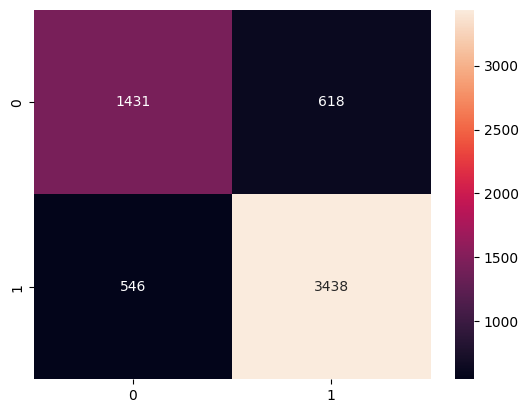

In [21]:
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras.layers import (
    TextVectorization,
    Embedding,
    Bidirectional,
    LSTM,
    Dense,
    Dropout,
)
from keras.regularizers import l2

# Text vectorization layer
lstm_vec_layer = TextVectorization(
    max_tokens=500, output_mode="int", output_sequence_length=500
)
lstm_vec_layer.adapt(X_train.values)

# LSTM model
lstm = Sequential(
    [
        lstm_vec_layer,
        Embedding(
            input_dim=len(lstm_vec_layer.get_vocabulary()),
            output_dim=128,
            embeddings_regularizer=l2(0.0005),
            mask_zero=True,
        ),
        Dense(128, activation="leaky_relu"),
        Dropout(0.3),
        Bidirectional(LSTM(64, kernel_regularizer=l2(0.0005))),
        Dense(64, activation="leaky_relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid"),
    ]
)

lstm.compile(
    optimizer="adam",
    loss="binary_crossentropy",
    metrics=["accuracy"],
)

# Fit model
early_stopping = EarlyStopping(
    monitor="val_loss", patience=8, mode="min", restore_best_weights=True
)
lstm.fit(
    train_ds,
    epochs=100,
    callbacks=[early_stopping],
    validation_data=val_ds,
    class_weight=class_weights,
)

# Add methods so that show_eval can be used
lstm.score = lambda X, y: lstm.evaluate(X.to_numpy(), y, verbose=0)[1]
lstm.tf_predict = lstm.predict
lstm.predict = lambda X: lstm.tf_predict(X, verbose=0).flatten().round().astype(int)

print()
show_eval(lstm, X_train, X_val, y_train, y_val)

### BERT (Pre-trained Transformer)


In [22]:
import tensorflow as tf

# Speed up training with mixed precision
tf.keras.mixed_precision.set_global_policy("mixed_float16")

# Create datasets
BATCH_SIZE = 32
train_ds = (
    tf.data.Dataset.from_tensor_slices((X_train, y_train))
    .repeat()
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)
val_ds = (
    tf.data.Dataset.from_tensor_slices((X_val, y_val))
    .batch(BATCH_SIZE)
    .prefetch(tf.data.AUTOTUNE)
)

# Use class weights instead of oversampling
neg = y_train.value_counts()[0]
pos = y_train.value_counts()[1]
total = y_train.shape[0]

weight_neg = (1 / neg) * (total / 2.0)
weight_pos = (1 / pos) * (total / 2.0)
class_weights = {0: weight_neg, 1: weight_pos}

Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 206s 515ms/step - loss: 0.6322 - sparse_categorical_accuracy: 0.6082 - val_loss: 0.4026 - val_sparse_categorical_accuracy: 0.8205
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 417ms/step - loss: 0.4635 - sparse_categorical_accuracy: 0.7819 - val_loss: 0.3977 - val_sparse_categorical_accuracy: 0.8253
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 81s 404ms/step - loss: 0.4220 - sparse_categorical_accuracy: 0.8079 - val_loss: 0.4139 - val_sparse_categorical_accuracy: 0.8112
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 82s 411ms/step - loss: 0.3779 - sparse_categorical_accuracy: 0.8347 - val_loss: 0.4574 - val_sparse_categorical_accuracy: 0.8021
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 414ms/step - loss: 0.3414 - sparse_categorical_accuracy: 0.8617 - val_loss: 0.3242 - val_sparse_categorical_accuracy: 0.8659
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 83s 416ms/step - loss: 0.3087 - sparse_categorical_accuracy: 0.8770 - val_loss: 0.3218 - val_sparse_categorical_ac

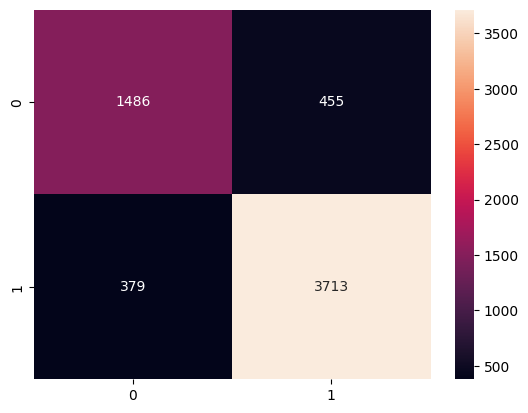

In [23]:
from keras.callbacks import EarlyStopping
from keras_nlp.models import BertClassifier

# Pre-trained BERT model
bert = BertClassifier.from_preset(
    "bert_medium_en_uncased",
    num_classes=2,
)

# Fit model
early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, mode="min", restore_best_weights=True
)
bert.fit(
    train_ds,
    epochs=30,
    callbacks=[early_stopping],
    validation_data=val_ds,
    class_weight=class_weights,
    steps_per_epoch=200,  # Break up epochs for better early stopping
)

# Add methods so that show_eval can be used
bert.score = lambda X, y: bert.evaluate(X, y, verbose=0)[1]
bert.tf_predict = bert.predict
bert.predict = lambda X: bert.tf_predict(X, verbose=0).argmax(axis=1)

print()
show_eval(bert, X_train, X_val, y_train, y_val)

### Save best model


In [24]:
!mkdir ./checkpoints
bert.save("checkpoints/bert-medium-druggie-6.keras")